# 네이버 영화 이진분류

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as atf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip install JPype1
pip install konlpy

Process is interrupted.


In [4]:
%env JAVA_HOME='/usr/lib/jvm/java-8-openjdk-arm64'

env: JAVA_HOME='/usr/lib/jvm/java-8-openjdk-arm64'


In [5]:
%cd /content

/content


In [6]:
!pwd

/content


In [7]:
!git clone http://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [8]:
train_data = pd.read_csv('/content/nsmc/ratings_train.txt', sep = '\t')
# 역슬래시는 escape

In [9]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
train_data.count()

id          150000
document    149995
label       150000
dtype: int64

In [11]:
train_data.isna().sum()

id          0
document    5
label       0
dtype: int64

In [12]:
train_data.duplicated().sum()

0

In [13]:
train_data['document'].duplicated().sum()

3817

In [14]:
train_data.drop_duplicates(subset = ['document'], inplace=True)

In [15]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [16]:
## 결측치 삭제

train_data = train_data.dropna()

In [17]:
train_data['document'] = train_data['document'].str.replace("[^가-힣 ]",'')

<ipython-input-17-87d43d1bd357>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^가-힣 ]",'')


In [18]:
train_data.head(10)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [19]:
train_data['document'] = train_data['document'].str.replace("^ +","")
train_data['document'] = train_data['document'].replace('', np.nan)
train_data = train_data.dropna()
# space로 시작하고, 글자가 있으면 space를 없는거로 바꿔줌줌

<ipython-input-19-1385d27ab748>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("^ +","")


In [20]:
train_data.head(10)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


# 토큰화

In [24]:
from tqdm import tqdm
from konlpy.tag import Okt

stopwords = ['의','가','이','은','들','자','는']
okt = Okt()
x_train = []

for sentence in tqdm(train_data['document']):
  temp_x = okt.morphs(sentence, stem=True) # 형태소 분석
  temp_x = [word for word in temp_x if not word in stopwords] # stopwords가 없으면 저장장
  x_train.append(temp_x)


100%|██████████| 145248/145248 [08:30<00:00, 284.40it/s]


In [25]:
x_train[:10]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '하다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다'],
 ['막',
  '걸음',
  '마',
  '떼다',
  '세',
  '부터',
  '초등학교',
  '학년',
  '생인',
  '살다',
  '영화',
  '별',
  '반개',
  '도',
  '아깝다',
  '움'],
 ['원작', '긴장감', '을', '제대로', '살리다', '하다'],
 ['별',
  '반개',
  '도',
  '아깝다',
  '욕',
  '나오다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '드라마',
  '가족',
  '도',
  '없다',
  '연기',
  '못',
  '하다',
  '사람',
  '만',
  '모',
  '엿',
  '네'],
 ['액션', '없다', '재미', '있다', '몇', '안되다', '영화'],
 ['왜케',
  '평점',
  '낮다',
  '꽤',
  '볼',
  '만',
  '한',
  '데',
  '헐리우드',
  '식',
  '화려하다',
  '너무',
  '길들이다',
  '있다']]

# 정수 인코딩

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 20000, oov_token='<oov>')
tokenizer.fit_on_texts(x_train) 

In [27]:
print(tokenizer.word_index)

{'<oov>': 1, '영화': 2, '보다': 3, '하다': 4, '에': 5, '을': 6, '도': 7, '를': 8, '없다': 9, '이다': 10, '있다': 11, '좋다': 12, '너무': 13, '다': 14, '정말': 15, '한': 16, '되다': 17, '재밌다': 18, '적': 19, '만': 20, '같다': 21, '진짜': 22, '으로': 23, '로': 24, '아니다': 25, '않다': 26, '점': 27, '에서': 28, '만들다': 29, '과': 30, '나오다': 31, '연기': 32, '것': 33, '평점': 34, '내': 35, '최고': 36, '그': 37, '나': 38, '안': 39, '인': 40, '스토리': 41, '생각': 42, '못': 43, '왜': 44, '드라마': 45, '게': 46, '감동': 47, '사람': 48, '보고': 49, '이렇다': 50, '말': 51, '고': 52, '아깝다': 53, '더': 54, '배우': 55, '때': 56, '와': 57, '감독': 58, '아': 59, '거': 60, '그냥': 61, '재미있다': 62, '요': 63, '재미': 64, '시간': 65, '내용': 66, '뭐': 67, '까지': 68, '중': 69, '주다': 70, '좀': 71, '자다': 72, '하고': 73, '지루하다': 74, '재미없다': 75, '네': 76, '쓰레기': 77, '수': 78, '모르다': 79, '가다': 80, '들다': 81, '그렇다': 82, '싶다': 83, '지': 84, '작품': 85, '사랑': 86, '알다': 87, '하나': 88, '다시': 89, '마지막': 90, '볼': 91, '잘': 92, '이건': 93, '정도': 94, '저': 95, '완전': 96, '오다': 97, '많다': 98, '처음': 99, '장면': 100, '액션': 101, '주인공': 102, 

In [28]:
x_train = tokenizer.texts_to_sequences(x_train)
x_train[:5]

[[59, 457, 22, 264, 661],
 [932, 459, 49, 604, 2, 219, 1439, 32, 955, 676, 26],
 [388, 2416, 1, 2236, 5620, 3, 227, 16, 14],
 [6428, 112, 7643, 222, 64, 9, 34, 3563],
 [1018,
  19233,
  37,
  9072,
  32,
  830,
  2,
  2550,
  28,
  1101,
  245,
  4,
  14113,
  19234,
  1071,
  257,
  245]]

In [29]:
y_train = train_data['label']

In [30]:
y_train[:10]

0    0
1    1
2    0
3    0
4    1
5    0
6    0
7    0
8    1
9    1
Name: label, dtype: int64

In [31]:
len(tokenizer.word_index)

43082

In [32]:
drop_train = []

for index, sentence in enumerate(x_train):
    if len(sentence) < 2: # 스페이스가 하나거나 한글자짜리가 들어오는거 삭제제
        drop_train.append(index)

In [33]:
len(drop_train)

2688

In [34]:
x_train = np.delete(x_train, drop_train, axis=0)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [35]:
len(x_train)

142560

In [36]:
review_len = [len(x) for x in x_train]
print(review_len)

[5, 11, 9, 8, 17, 16, 6, 38, 7, 14, 7, 13, 16, 18, 25, 5, 24, 13, 16, 14, 14, 5, 44, 8, 5, 12, 5, 3, 10, 18, 8, 6, 7, 5, 7, 10, 8, 6, 7, 4, 23, 5, 11, 28, 9, 40, 17, 6, 48, 19, 13, 11, 13, 2, 29, 2, 3, 7, 9, 9, 28, 12, 45, 26, 13, 11, 9, 7, 37, 7, 4, 16, 7, 2, 18, 3, 11, 4, 17, 5, 4, 5, 2, 3, 5, 6, 6, 6, 2, 7, 5, 8, 3, 6, 6, 12, 16, 9, 9, 8, 4, 15, 4, 8, 11, 11, 13, 7, 15, 2, 4, 4, 11, 4, 30, 16, 9, 3, 2, 7, 6, 16, 41, 10, 2, 5, 3, 10, 7, 9, 13, 5, 14, 14, 12, 46, 2, 4, 4, 39, 21, 12, 48, 9, 11, 4, 3, 3, 20, 9, 5, 6, 13, 7, 35, 49, 13, 2, 14, 10, 27, 39, 6, 5, 4, 15, 2, 4, 14, 6, 37, 6, 36, 4, 13, 4, 6, 29, 8, 4, 13, 13, 17, 18, 13, 5, 18, 10, 25, 8, 11, 6, 54, 16, 6, 11, 3, 13, 6, 4, 7, 7, 11, 3, 11, 12, 9, 12, 10, 27, 7, 20, 11, 4, 12, 5, 6, 26, 10, 30, 10, 50, 43, 6, 5, 10, 15, 9, 8, 8, 9, 11, 12, 14, 8, 9, 4, 5, 7, 13, 3, 5, 2, 11, 7, 8, 3, 12, 7, 23, 5, 15, 12, 5, 4, 30, 9, 7, 6, 2, 6, 3, 6, 6, 16, 16, 2, 11, 31, 9, 14, 32, 7, 4, 18, 2, 23, 10, 43, 3, 10, 33, 5, 24, 6, 4, 17, 15, 

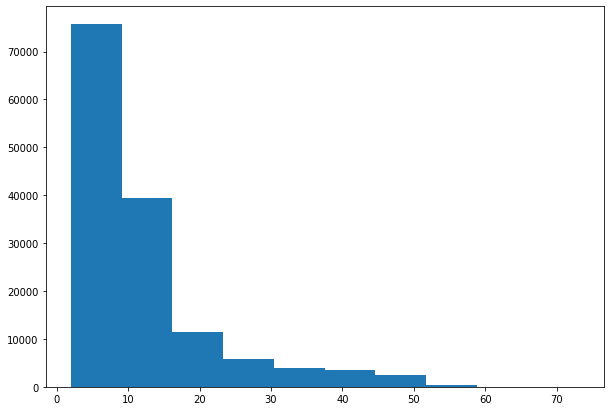

In [37]:
## 패딩

plt.figure(figsize = (10, 7))
plt.hist(review_len)
plt.show()

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=30)
x_train[:10]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    59,   457,
           22,   264,   661],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   932,   459,    49,   604,     2,   219,  1439,    32,
          955,   676,    26],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   388,  2416,     1,  2236,  5620,     3,
          227,    16,    14],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  6428,   112,  7643,   222,    64,
            9,    34,  3563],
       [    0,     0,     0,

# 모델

In [39]:
model = keras.Sequential([
    layers.Embedding(20000 ,16,input_length = 30), # len(tokenizer.word_index) # 문장의 길이
    layers.LSTM(128, activation = 'tanh'),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

EPOCHS = 15
BATCH_SIZE = 32
log = model.fit(x_train,y_train,
                epochs = EPOCHS,
                batch_size = BATCH_SIZE,
                validation_split = (0.2),
                verbose = 1
)

Epoch 1/15
3564/3564 [==============================] - 26s 5ms/step - loss: 0.6934 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5029
Epoch 2/15
3564/3564 [==============================] - 19s 5ms/step - loss: 0.6918 - acc: 0.5220 - val_loss: 0.6941 - val_acc: 0.5003
Epoch 3/15
3564/3564 [==============================] - 19s 5ms/step - loss: 0.6852 - acc: 0.5509 - val_loss: 0.6988 - val_acc: 0.4966
Epoch 4/15
3564/3564 [==============================] - 19s 5ms/step - loss: 0.6752 - acc: 0.5768 - val_loss: 0.7091 - val_acc: 0.4952
Epoch 5/15
3564/3564 [==============================] - 19s 5ms/step - loss: 0.6633 - acc: 0.5975 - val_loss: 0.7186 - val_acc: 0.4977
Epoch 6/15
3564/3564 [==============================] - 19s 5ms/step - loss: 0.6501 - acc: 0.6159 - val_loss: 0.7272 - val_acc: 0.4999
Epoch 7/15
3564/3564 [==============================] - 19s 5ms/step - loss: 0.6371 - acc: 0.6316 - val_loss: 0.7557 - val_acc: 0.5018
Epoch 8/15
3564/3564 [==============================] -

In [41]:
def predict_review(review):
  sentence = okt.morphs(review, stem=True) # 토큰화
  sentence = [word for word in sentence if not word in stopwords] # 불용어제거
  sentence = tokenizer.texts_to_sequences([sentence]) # 정수 인코딩
  sentence = pad_sequences(sentence, maxlen = 30) # 패딩
  score = float(model.predict(sentence)) # 예측

  if score > 0.5:
    print(f"{score: .2f}% 긍정")
  else:
    print(f"{score: .2f}% 부정")

In [44]:
review = ['씨발 영화 존나게 재미없네 보다 졸려 뒤지는줄 ㅋㅋ','병신','호구새끼','영화만들지마라 제작자 개새끼야','좆같이 재미없네','만든새끼 누구냐?']
for i in review:
  predict_review(i)

1/1 [==============================] - 0s 17ms/step
 0.38% 부정
1/1 [==============================] - 0s 15ms/step
 0.33% 부정
1/1 [==============================] - 0s 15ms/step
 0.60% 긍정
1/1 [==============================] - 0s 15ms/step
 0.17% 부정
1/1 [==============================] - 0s 15ms/step
 0.72% 긍정
1/1 [==============================] - 0s 16ms/step
 0.42% 부정
